In [80]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_absolute_error

In [2]:
dfCCO = pd.read_csv(r"..\Data\cco_cost_monthly.csv")

In [3]:
dfPYCO = pd.read_csv(r"..\Data\pyco_cost_monthly.csv", low_memory=False)

In [4]:
dfXCO = pd.read_csv(r"..\Data\xco_cost_monthly.csv")

In [29]:
def process_data(df):
    dfNew = df.groupby("invoice_month").agg({"total_cost": "sum"})
    dfNew.index = pd.to_datetime(dfNew.index)
    return dfNew

In [30]:
dfPYCO_processed = process_data(dfPYCO)
dfXCO_processed = process_data(dfXCO)
dfCCO_processed = process_data(dfCCO)

In [37]:
dfPYCO_processed.index[0]

Timestamp('2019-09-01 00:00:00')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

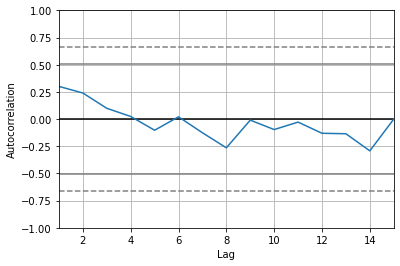

In [8]:
pd.plotting.autocorrelation_plot(dfPYCO_processed)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

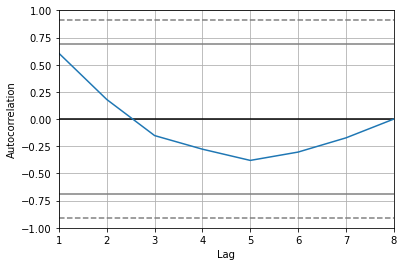

In [11]:
pd.plotting.autocorrelation_plot(dfCCO_processed)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

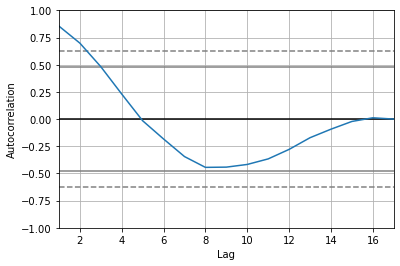

In [12]:
pd.plotting.autocorrelation_plot(dfXCO_processed)

In [18]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.80)
    train, test = X.total_cost[0:train_size], X.total_cost[train_size:]
    history = train.to_list()
    test = test.to_list()
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mae = mean_absolute_error(test, predictions)
    return mae

In [19]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mae = evaluate_arima_model(dataset, order)
                    if mae < best_score:
                        best_score, best_cfg = mae, order
                        print('ARIMA%s MAE=%.3f' % (order,mae))
                except:
                    continue
    print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
p_range = range(4)
d_range = range(4)
q_range = range(4)

evaluate_models(dfCCO_processed, p_range, d_range, q_range)

ARIMA(0, 0, 0) MAE=281.117
ARIMA(0, 0, 2) MAE=263.057
ARIMA(0, 0, 3) MAE=201.614
ARIMA(0, 1, 0) MAE=13.425
ARIMA(3, 1, 0) MAE=13.425
Best ARIMA(3, 1, 0) MAE=13.425


In [22]:
p_range = range(6)
d_range = range(4)
q_range = range(4)

evaluate_models(dfPYCO_processed, p_range, d_range, q_range)

ARIMA(0, 0, 0) MAE=1684.609
Best ARIMA(0, 0, 0) MAE=1684.609


In [23]:
p_range = range(6)
d_range = range(4)
q_range = range(4)

evaluate_models(dfXCO_processed, p_range, d_range, q_range)

ARIMA(0, 0, 0) MAE=979.281
ARIMA(0, 0, 1) MAE=766.462
ARIMA(0, 0, 2) MAE=494.024
ARIMA(0, 1, 0) MAE=433.965
ARIMA(0, 2, 0) MAE=349.404
ARIMA(0, 3, 1) MAE=321.697
ARIMA(1, 0, 1) MAE=306.825
ARIMA(2, 0, 0) MAE=300.180
Best ARIMA(2, 0, 0) MAE=300.180


In [32]:
dfPYCO_processed

,total_cost
invoice_month,
2019-09-01,11868.213465
2019-10-01,10742.465921
2019-11-01,10572.923600
2019-12-01,8721.969470
2020-01-01,8752.106507
2020-02-01,7094.260716
2020-03-01,8728.033331
2020-04-01,7154.925511
2020-05-01,6489.349368


In [51]:
mod = sm.tsa.ARIMA(dfPYCO_processed, order=(3,0,0)).fit()

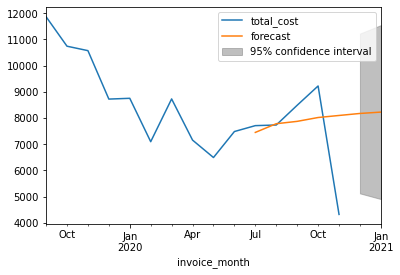

In [52]:
fig, ax = plt.subplots()
ax = dfPYCO_processed.loc["2019-09-01":].plot(ax=ax)
fig = mod.plot_predict("2020-07-01", "2021-01-01", dynamic=True, ax=ax, plot_insample=False)

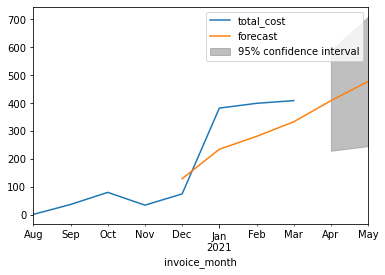

In [72]:
mod = sm.tsa.ARIMA(dfCCO_processed, order=(2,1,0)).fit()
fig, ax = plt.subplots()
ax = dfCCO_processed.plot(ax=ax)
fig = mod.plot_predict(dfCCO_processed.index[4], "2021-05-01", dynamic=True, ax=ax, plot_insample=False)

In [83]:
expsmooth = SimpleExpSmoothing(dfPYCO_processed, initialization_method="estimated").fit()

<AxesSubplot:xlabel='invoice_month'>

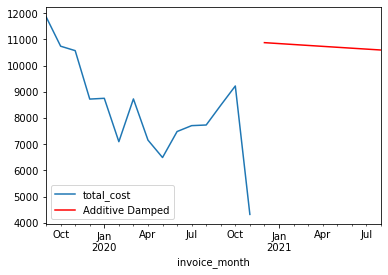

In [93]:
fig, ax = plt.subplots()
ax = dfPYCO_processed.loc["2019-09-01":].plot(ax=ax)
fit3 = Holt(dfPYCO_processed, exponential=True, initialization_method="estimated").fit()
fcast3 = fit3.forecast(9).rename("Additive Damped")
fcast3.plot(ax=ax, color='red', legend=True)